In [57]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from nltk.corpus import stopwords
import string
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

#### Data set disponível em: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [8]:
messages = pd.read_csv('C:/Users/Samsung/Documents/GitHub-Datas/Machine_Learnin_Steps/Natural Language/SMSSpamCollection', sep='\t', names = ['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
messages['lenght'] = messages['message'].apply(len)
messages.head()

,label,message,lenght
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


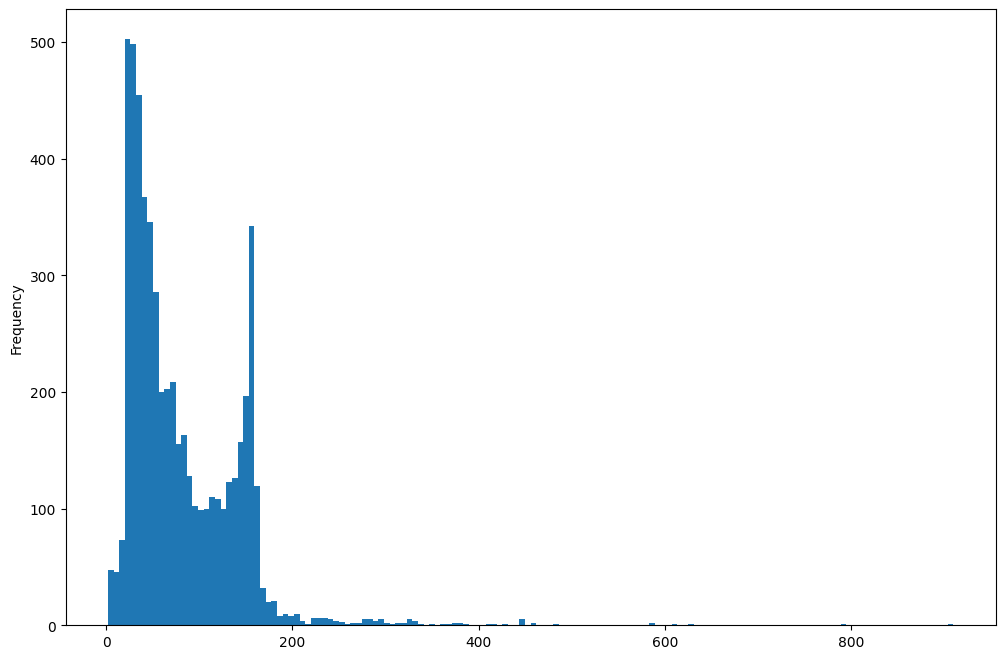

In [16]:
plt.figure(figsize=(12, 8)) 
messages['lenght'].plot(kind='hist',bins= 150)
plt.show()

In [17]:
messages['lenght'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: lenght, dtype: float64

In [21]:
messages[messages['lenght']> 700]['message']

1085    For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..
1863                                                                             

#### Distribuições diferentes para cada tipo de classificação de dados.

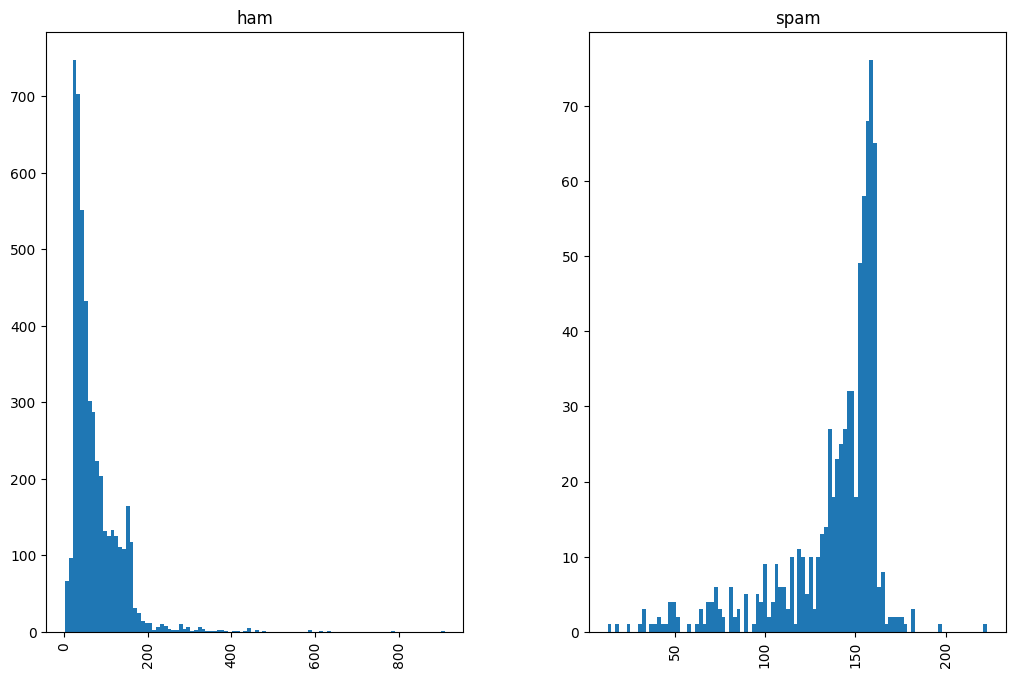

In [24]:
messages.hist(bins=100,column='lenght', by='label', figsize=(12, 8))
plt.show()

In [26]:

# Remove pontuação de cada mensagem
messages['message_cleaned'] = messages['message'].apply(
    lambda x: ''.join(char for char in x if char not in string.punctuation)
)


In [27]:
messages['message_cleaned']

0                                                         Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat
1                                                                                                                                        Ok lar Joking wif u oni
2          Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive entry questionstd txt rateTCs apply 08452810075over18s
3                                                                                                                    U dun say so early hor U c already then say
4                                                                                                    Nah I dont think he goes to usf he lives around here though
                                                                                  ...                                                                           
5567    This is the 2nd time we ha

##### Tirando pontuação, palavras desnecessárias para contexto, deixando tudo minusculo e transformando em vetor.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
stop_words = set(stopwords.words('english'))

# Definindo a função de limpeza
def text_process(message):
    # Remove pontuações, divide em palavras e elimina stopwords
    return [
        word for word in ''.join(char for char in message if char not in string.punctuation).split()
        if word.lower() not in stop_words
    ]

# Criando o CountVectorizer com o analisador customizado
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message_cleaned'])

#### Qtd de vetores.

In [35]:
print(len(bow_transformer.vocabulary_))

11425


##### Transformando em vetor e traduzindo.

In [36]:
message4 = messages['message_cleaned'][3]
print(message4)

U dun say early hor U c already say


In [37]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
(1, 11425)


In [39]:
print(bow_transformer.get_feature_names_out()[9554])

say


In [40]:
messages_bow = bow_transformer.transform(messages['message'])

#### Verificando quantidade de vetores que não são zeros.

In [41]:
print(messages_bow.shape)
print(messages_bow.nnz)

(5572, 11425)
50548


#### Apenas aproximidamente 7% do vetor é não zero

In [42]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
tdidf_transformer = TfidfTransformer()
tdidf_transformer = tdidf_transformer.fit(messages_bow)

#### Ou seja a palavra 'say' para o ajuste desse modelo tem peso de aproximadamente 0.5385

In [44]:
tfidf4 = tdidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


In [45]:
from sklearn.naive_bayes import MultinomialNB

In [47]:
messages_tfidf = tdidf_transformer.transform(messages_bow)
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

In [48]:
print('Predito', spam_detect_model.predict(tfidf4)[0])
print('Esperado', messages['label'][3])

Predito ham
Esperado ham


In [50]:
from sklearn.model_selection import train_test_split
msg_train, msg_test, label_train, label_test = train_test_split(messages['message_cleaned'], messages['label'], test_size = 0.2)

In [51]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [52]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002662D9C9A60>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [53]:
pred = pipeline.predict(msg_test)

In [55]:
print(classification_report(pred , label_test))

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1014
        spam       0.69      1.00      0.81       101

    accuracy                           0.96      1115
   macro avg       0.84      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115



##### Podemos rodar também com classificador Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
])

In [68]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000002662D9C9A60>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [69]:
pred = pipeline.predict(msg_test)

In [70]:
print(classification_report(pred , label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.99       993
        spam       0.83      1.00      0.91       122

    accuracy                           0.98      1115
   macro avg       0.91      0.99      0.95      1115
weighted avg       0.98      0.98      0.98      1115

